In [16]:
import numpy as np
import pandas as pd
import sys,os
from matplotlib import pyplot as plt
%matplotlib inline
from alabtools.analysis import HssFile
from alabtools.plots import write_pdb
from sklearn import preprocessing

In [17]:
# Read in HSS file
hss = HssFile('CTRL.hss', 'r')
print(hss.coordinates.shape)
# First, we need to know which beads that represent the diffrent copies belong to the same bin in genome
copy_index=hss.index.copy_index
print(len(copy_index))

(25965, 1000, 3)
13640


In [53]:
import os
os.getcwd()

'/u/project/xjzhou/wyeast/wy_data/undergrad_tutorial/IGM_tutorial'

In [1]:
hss.index

for i in range(len(hss.index)):
    print(hss.index.chromstr[i], hss.index.start[i], hss.index.end[i])

SyntaxError: unexpected EOF while parsing (<ipython-input-1-3c9dd2543334>, line 4)

In [18]:
# Estimate nuclear ellipsoidal semi-axes from the coordinates
xmax = np.max(hss.coordinates[:, :, 0]) / 1000  # in um
ymax = np.max(hss.coordinates[:, :, 1]) / 1000
zmax = np.max(hss.coordinates[:, :, 2]) / 1000
print('x: {} um, y: {} um, z: {} um'.format(xmax, ymax, zmax))

# Get nucleus radius in nm
nucleusRadius = (xmax * 1000, ymax * 1000, zmax * 1000)

# Calculate the volume of the ellipsoid
vol = 4/3*np.pi*xmax*ymax*zmax
print('Mouse cardiomyocytes nuclear volume: {} um^3'.format(vol))

# Calculate reference volume of a 4.5 um sphere
vol_ref = 4/3*np.pi*(4.5)**3
print('Reference 4.5 um sphere nuclear volume: {} um^3'.format(vol_ref))

x: 10.806 um, y: 3.255090087890625 um, z: 3.254719970703125 um
Mouse cardiomyocytes nuclear volume: 479.5459348966677 um^3
Reference 4.5 um sphere nuclear volume: 381.7035074111598 um^3


In [19]:
# Save a PDB structure for a specific structure
structureID = 100

# Get the XYZ coordinates
# Convert from nm to um
coord = hss.coordinates[:, structureID, :].astype(float) / 1000

# Get the chromosome string array
chroms = hss.index.chromstr
# Remove the 'chr' part from every element of chroms
chroms = np.array([chrom.replace('chr', '') for chrom in chroms])

# Get the copy (array of 0 or 1)
copy = hss.index.copy
# Convert 0-1 int array to 'A'-'B' string array
copy_AB = np.array(['A', 'B'])[copy]

# Convert start to kb
start_kb = hss.index.start / 1000

# Create data for PDB structure
data_for_pdb = {'x': coord[:, 0],
                'y': coord[:, 1],
                'z': coord[:, 2],
                'residue_name': chroms,
                'chain_id': copy_AB,
                'occupancy': start_kb}

# Write PDB structure
write_pdb('./TAC_struct{}.pdb'.format(structureID), data_for_pdb)



<_io.TextIOWrapper name='./TAC_struct100.pdb' mode='w' encoding='UTF-8'>

In [20]:
hss.radii

array([124.41722, 124.41722, 124.41722, ..., 124.41722, 124.41722,
       124.41722], dtype=float32)

In [21]:
# get chromosome names, start and end positions of the bins
index = hss.index
index_chroms = index.chromstr
index_starts = index.start
index_ends = index.end


In [22]:
index_ends

array([  200000,   400000,   600000, ..., 61200000, 61400000, 61600000],
      dtype=int32)

In [23]:
# iterate keys over copy_index, and get the coordinates of the beads that belong to the same bin, 
# then get the average radials of the beads that belong to the same bin, write chr start end and average 
# radial to a file

#specify the radius of nucleus

nucleusRadius=(10806, 3255, 3255)

struc_feature_file='mouse_heart_CTRL_RAD.bed'

# Ensure the file is empty before starting the loop
with open(struc_feature_file, 'w') as f:
    pass

for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=nucleusRadius)
    #write chr start end and average radial to a file
    with open(struc_feature_file, 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(np.mean(radials))+'\n')
    f.close()


In [24]:
radial=pd.read_csv('mouse_heart_CTRL_RAD.bed', sep='\t', header=None)
radial

,0,1,2,3
0,chr1,0,200000,0.920086
1,chr1,200000,400000,0.915286
2,chr1,400000,600000,0.909815
3,chr1,600000,800000,0.908277
4,chr1,800000,1000000,0.895536
...,...,...,...,...
13635,chr21,90800000,91000000,0.650341
13636,chr21,91000000,91200000,0.735761
13637,chr21,91200000,91400000,0.809493
13638,chr21,91400000,91600000,0.860040


In [25]:
#compute the std of the radials of the beads that belong to the same bin
struc_feature_file='mouse_heart_CTRL_RAD_std.bed'

# Ensure the file is empty before starting the loop
with open(struc_feature_file, 'w') as f:
    pass

for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=nucleusRadius)
    #write chr start end and average radial to a file
    with open(struc_feature_file, 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(np.std(radials))+'\n')
    f.close()

In [26]:
#compute the deltaRAD
#first, we need compute the mean RAD across the genome
#read the radial_std.txt, which contains the std of radial of each bin
radial_std=pd.read_csv('mouse_heart_CTRL_RAD_std.bed', sep='\t', header=None)
#compute the mean RAD across the genome, which is the mean of the fourth column of the radial_std.txt
mean_radial_std=np.mean(radial_std[3])
#compute the std of the radials of the beads that belong to the same bin
struc_feature_file='mouse_heart_CTRL_deltaRAD.bed'

# Ensure the file is empty before starting the loop
with open(struc_feature_file, 'w') as f:
    pass

#compute delta RAD of the bin
for bin in copy_index:
    #get chr, start, end, of the bin
    bead_0=copy_index[bin][0]
    chr=index_chroms[bead_0]
    start=index_starts[bead_0]
    end=index_ends[bead_0]
    #get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=nucleusRadius)
    #write chr start end and average radial to a file
    with open(struc_feature_file, 'a') as f:
        f.write(chr+'\t'+str(start)+'\t'+str(end)+'\t'+str(np.log2(np.std(radials)/mean_radial_std))+'\n')
    f.close()

In [30]:
data=pd.read_csv('mouse_heart_CTRL_RAD.bed',sep='\t',header=None)

In [31]:
data

,0,1,2,3
0,chr1,0,200000,0.920086
1,chr1,200000,400000,0.915286
2,chr1,400000,600000,0.909815
3,chr1,600000,800000,0.908277
4,chr1,800000,1000000,0.895536
...,...,...,...,...
13635,chr21,90800000,91000000,0.650341
13636,chr21,91000000,91200000,0.735761
13637,chr21,91200000,91400000,0.809493
13638,chr21,91400000,91600000,0.860040


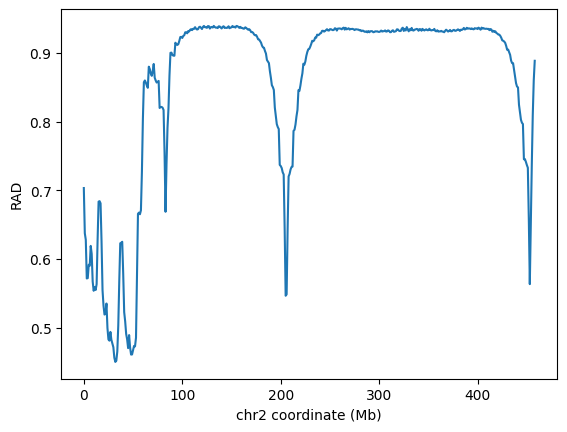

In [35]:
#plot the delta RAD for chr2
chr2=data[data[0]=='chr21']
chr2_coord=chr2[1]/200000
chr2_radial=chr2[3]

plt.plot(chr2_coord,chr2_radial)

plt.xlabel('chr2 coordinate (Mb)')
plt.ylabel('RAD')
#plt.ylim(0.5,0.9)
plt.show()

In [36]:
# Generate RAD, deltaRAD for another sample, we can integrate the code to generating RAD and RADstd in the same loop
# Read in HSS file
hss = HssFile('TAC.hss', 'r')
# First, we need to know which beads that represent the diffrent copies belong to the same bin in genome
copy_index=hss.index.copy_index
# get chromosome names, start and end positions of the bins
index = hss.index
index_chroms = index.chromstr
index_starts = index.start
index_ends = index.end


# Assume hss.getBeadRadialPositions and other necessary variables are defined elsewhere

# Specify the radius of nucleus
nucleusRadius = (10806, 3255, 3255)

# File names for output
mean_file = 'mouse_heart_TAC_RAD.bed'
std_file = 'mouse_heart_TAC_RAD_std.bed'
delta_rad_file = 'mouse_heart_TAC_deltaRAD.bed'

# Initialize lists to store computed values for later use in deltaRAD calculation
mean_radials = []

# Ensure the files are empty before starting the loop
open(mean_file, 'w').close()
open(std_file, 'w').close()
open(delta_rad_file, 'w').close()

# Compute mean and std for each bin and write to respective files
for bin in copy_index:
    # Get chr, start, end, of the bin
    bead_0 = copy_index[bin][0]
    chr = index_chroms[bead_0]
    start = index_starts[bead_0]
    end = index_ends[bead_0]

    # Get the radials of the beads that belong to the same bin
    radials = hss.getBeadRadialPositions(copy_index[bin], nucleusRadius=nucleusRadius)
    mean_radial = np.mean(radials)
    std_radial = np.std(radials)

    # Store the mean radial for later use
    mean_radials.append(mean_radial)

    # Write chr, start, end, and mean radial to the mean file
    with open(mean_file, 'a') as f_mean:
        f_mean.write(f"{chr}\t{start}\t{end}\t{mean_radial}\n")

    # Write chr, start, end, and std radial to the std file
    with open(std_file, 'a') as f_std:
        f_std.write(f"{chr}\t{start}\t{end}\t{std_radial}\n")

# Compute the genome-wide mean of the radial standard deviations
genome_mean_std = np.mean(mean_radials)

# Compute deltaRAD for each bin and write to the deltaRAD file
for i, bin in enumerate(copy_index):
    # Get chr, start, end, of the bin (this is repeated but required for the current loop)
    bead_0 = copy_index[bin][0]
    chr = index_chroms[bead_0]
    start = index_starts[bead_0]
    end = index_ends[bead_0]

    # Compute deltaRAD
    delta_rad = np.log2(mean_radials[i] / genome_mean_std)

    # Write chr, start, end, and deltaRAD to the deltaRAD file
    with open(delta_rad_file, 'a') as f_delta:
        f_delta.write(f"{chr}\t{start}\t{end}\t{delta_rad}\n")


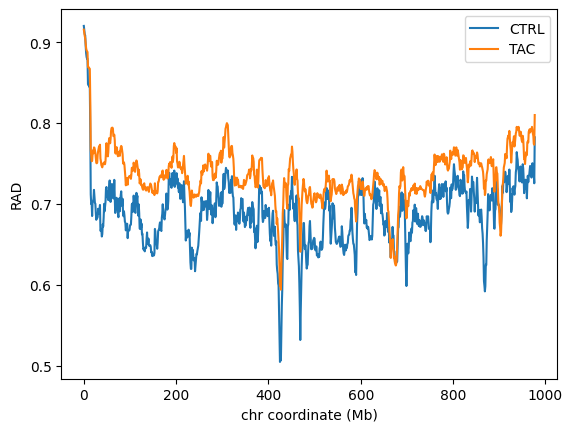

In [45]:
#First, let's try to visualize the RAD difference of two dataset, you may change the chr name freely to explore

CTRL_RAD_data=pd.read_csv('mouse_heart_CTRL_RAD.bed',sep='\t',header=None)
TAC_RAD_data=pd.read_csv('mouse_heart_TAC_RAD.bed',sep='\t',header=None)

# Assuming 'data' is your CTRL dataset
chr_CTRL = CTRL_RAD_data[CTRL_RAD_data[0] == 'chr1']  # make sure to filter 'chr' if that's what you're after
chr_coord_CTRL = chr_CTRL[1] / 200000  # convert coordinates to Mb
chr_radial_CTRL = chr_CTRL[3]

# Assuming 'other_data' is your TAC dataset
chr_TAC = TAC_RAD_data[TAC_RAD_data[0] == 'chr1']
chr_coord_TAC = chr_TAC[1] / 200000  # convert coordinates to Mb
chr_radial_TAC = chr_TAC[3]

# Plotting the CTRL dataset
plt.plot(chr_coord_CTRL, chr_radial_CTRL, label='CTRL')

# Overlaying the TAC dataset
plt.plot(chr_coord_TAC, chr_radial_TAC, label='TAC')

# Adding labels and a legend
plt.xlabel('chr coordinate (Mb)')
plt.ylabel('RAD')
plt.legend()  # this adds the legend to the plot

# Uncomment the following line if you want to set a limit for the y-axis
# plt.ylim(0.5, 0.9)

# Show the plot
plt.show()


In [40]:
#You may noticed some interesting result, now let's compare the RAD difference in some more quantative manners
#first let's merge multiple input bed files into a single one

#append the rows to output tables
bdgs=['mouse_heart_CTRL_RAD.bed','mouse_heart_TAC_RAD.bed','mouse_heart_CTRL_deltaRAD.bed','mouse_heart_TAC_deltaRAD.bed',]
# Initialize an empty DataFrame for merging
data_merged = None
# Loop through each file and merge it into the data_merged DataFrame
for file in bdgs:
    # Read the current file into a DataFrame
    data = pd.read_csv(file, sep='\s+', header=None)
    
    # Extract the feature name from the file name (assuming it's the last part after the underscore, like 'RAD')
    prefix = file.split('.')[0]
    feature = prefix.split('_')[-2]+'_'+prefix.split('_')[-1]  # remove the '.bed' extension
    
    # Rename the columns of the DataFrame
    data.columns = ['chr', 'start', 'end', feature]
    
    # If data_merged is None, it means this is the first file, so assign it to data_merged
    if data_merged is None:
        data_merged = data
    else:
        # Merge the current DataFrame into the data_merged DataFrame on the 'chr', 'start', 'end' columns
        data_merged = pd.merge(data_merged, data, on=['chr', 'start', 'end'])

In [41]:
data_merged

,chr,start,end,CTRL_RAD,TAC_RAD,CTRL_deltaRAD,TAC_deltaRAD
0,chr1,0,200000,0.920086,0.915523,-0.720110,0.342943
1,chr1,200000,400000,0.915286,0.911119,-0.701280,0.335987
2,chr1,400000,600000,0.909815,0.907640,-0.683477,0.330467
3,chr1,600000,800000,0.908277,0.904812,-0.660943,0.325965
4,chr1,800000,1000000,0.895536,0.899154,-0.610291,0.316916
...,...,...,...,...,...,...,...
13635,chr21,90800000,91000000,0.650341,0.929468,-0.155184,0.364752
13636,chr21,91000000,91200000,0.735761,0.934197,-0.132831,0.372074
13637,chr21,91200000,91400000,0.809493,0.937414,-0.178687,0.377034
13638,chr21,91400000,91600000,0.860040,0.940188,-0.255037,0.381297


In [42]:
#Let's compute the fold change of RAD between TAC and CTRL
data_merged['log2_TAC_vs_CTRL_RAD']=np.log2(data_merged['TAC_RAD']/data_merged['CTRL_RAD'])

In [43]:
print(np.mean(data_merged['log2_TAC_vs_CTRL_RAD']))
print(np.min(data_merged['log2_TAC_vs_CTRL_RAD']))
print(np.max(data_merged['log2_TAC_vs_CTRL_RAD']))

0.10632178189920559
-0.052318646055986816
0.9059483784751167


<AxesSubplot:>

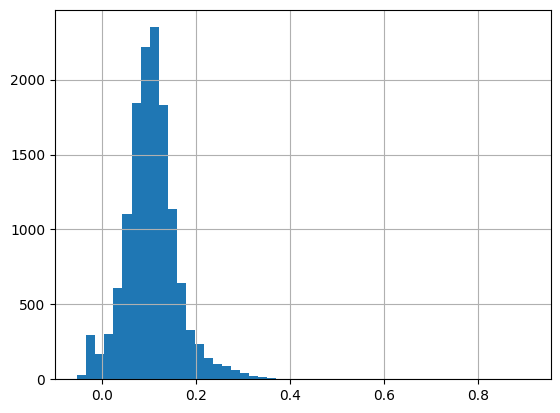

In [44]:
data_merged['log2_TAC_vs_CTRL_RAD'].hist(bins=50)

In [46]:

#We see in general RAD in TAC is higher than that in CTRL, to remove the bias of different IGM run/dataset, we may normalize RAD for each dataset before the comparision
scaler=preprocessing.StandardScaler().fit(data_merged[['CTRL_RAD']])
data_merged['CTRL_RAD_norm']=scaler.transform(data_merged[['CTRL_RAD']])
scaler=preprocessing.StandardScaler().fit(data_merged[['TAC_RAD']])
data_merged['TAC_RAD_norm']=scaler.transform(data_merged[['TAC_RAD']])
#Let's compute the fold change of RAD between TAC and CTRL
data_merged['diff_TAC_vs_CTRL_RAD_norm']=data_merged['TAC_RAD_norm']-data_merged['CTRL_RAD_norm']

<AxesSubplot:>

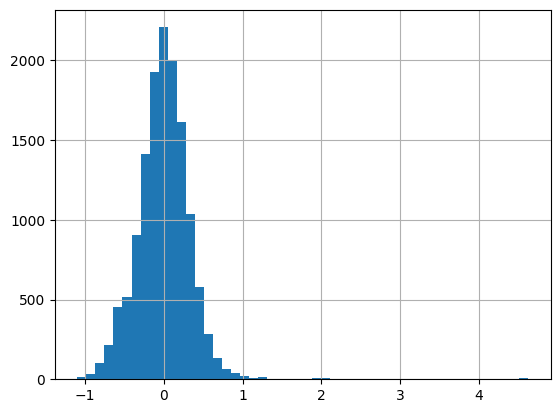

In [47]:
data_merged['diff_TAC_vs_CTRL_RAD_norm'].hist(bins=50)

In [51]:
data_merged[data_merged['diff_TAC_vs_CTRL_RAD_norm']>1]

,chr,start,end,CTRL_RAD,TAC_RAD,CTRL_deltaRAD,TAC_deltaRAD,log2_TAC_vs_CTRL_RAD,CTRL_RAD_norm,TAC_RAD_norm,log2_TAC_vs_CTRL_RAD_norm,diff_TAC_vs_CTRL_RAD_norm
868,chr1,173600000,173800000,0.599080,0.728342,-1.612993,0.012963,0.281866,-0.917937,0.090067,1.008004,1.008004
3058,chr4,73600000,73800000,0.605864,0.738010,-1.601837,0.031988,0.284645,-0.832237,0.223716,1.055953,1.055953
3133,chr4,88600000,88800000,0.606002,0.748997,-1.598377,0.053308,0.305639,-0.830504,0.375605,1.206109,1.206109
3300,chr4,122000000,122200000,0.608958,0.747585,-1.439741,0.050586,0.295896,-0.793159,0.356087,1.149246,1.149246
5020,chr7,7600000,7800000,0.515551,0.654188,-1.779362,-0.141947,0.343590,-1.973155,-0.935039,1.038116,1.038116
...,...,...,...,...,...,...,...,...,...,...,...,...
13633,chr21,90400000,90600000,0.657133,0.929593,-1.664972,0.364947,0.500414,-0.184562,2.872171,3.056733,3.056733
13634,chr21,90600000,90800000,0.563573,0.929516,-1.690289,0.364827,0.721877,-1.366498,2.871098,4.237596,4.237596
13635,chr21,90800000,91000000,0.650341,0.929468,-1.620368,0.364752,0.515208,-0.270369,2.870433,3.140802,3.140802
13636,chr21,91000000,91200000,0.735761,0.934197,-1.598015,0.372074,0.344490,0.808731,2.935810,2.127079,2.127079


### Try it! Explore the Data by Yourself and Achieve Your First Result
Now that we've mastered the technique of calculating the RAD difference between two cell lines, it's your turn to delve into the data. Are you ready to uncover the regions with significant RAD differences? Here are some strategies to guide your exploration:

#### 1. Experiment with Different Calculation Methods
Don't just stick to one - try various methods to compute the RAD difference. For instance, you could use subtraction, fold change, or other statistical measures. Each method could reveal different insights.
#### 2. Set Your Thresholds Wisely
Before you fix any thresholds, I'd highly recommend that you visualize the RAD differences with a histogram. This will give you a clearer understanding of how the values are distributed across the dataset.
#### 3. Normalization Techniques Matter
We've used the StandardScaler in our tutorial, but that's just the beginning. Dive into the documentation and test out other normalization methods. How do these changes affect your results?
#### 4. Evaluate Your Findings
The most straightforward way to assess the significance of the RAD differences is to visualize them. Make use of the code we provided to see how different parameter combinations highlight the regions with reliable RAD differences.
#### Remember, the goal is to find those key regions with confidence. Each step you take - from choosing a method to normalization - plays a crucial role in the robustness of your results. Happy exploring!